# Import section

In [11]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scikitplot as skplot
from sklearn import linear_model
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA

from context import ml_project
from ml_project.io import DataHandler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# To surpress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Download data - HowTo

1) Download the zip folder holding the data  
2) Create a directory inside the <PROJECT_ROOT_DIR>/data and give it a suitable name <DIR_NAME>, e.g. "task1a_data"   
3) Extract the files from the zip folder into <DIR_NAME>  
4) Set the correct <DIR_NAME> in the following cell...  

In [3]:
DIR_NAME = 'task1a_data'

# Load training data

In [36]:
data_handler = DataHandler(DIR_NAME)
train_data = data_handler.load_train_data()

train_X = train_data.drop(['y'], axis=1)
train_Y = train_data['y']

In [37]:
train_X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
Id,,,,,,,,,,
0,0.886865,0.400531,1.103694,0.135455,8.148069,9.787555,79.749674,0.045166,1.859346,1.0
1,0.303604,-1.661598,0.772695,1.696182,0.455550,86.413653,39.365705,-0.014858,0.821406,1.0
2,1.065927,-1.607320,0.063896,-0.724311,-0.088216,0.132828,-0.011718,-0.773193,-1.489933,1.0
3,0.049530,-0.780820,-1.653181,0.663369,-2.492097,-1.243722,3.099476,-1.037881,0.346979,1.0
4,0.417725,-1.150429,0.258384,0.045522,5.676019,-0.470274,-2.669283,0.632083,-0.510847,1.0


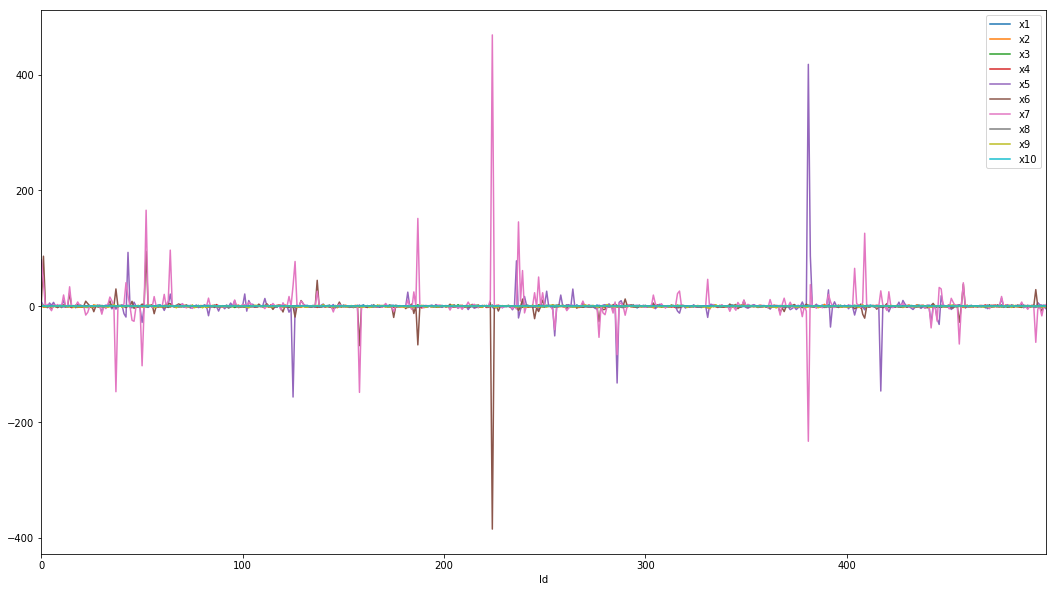

In [38]:
train_X.plot(figsize=(18, 10))

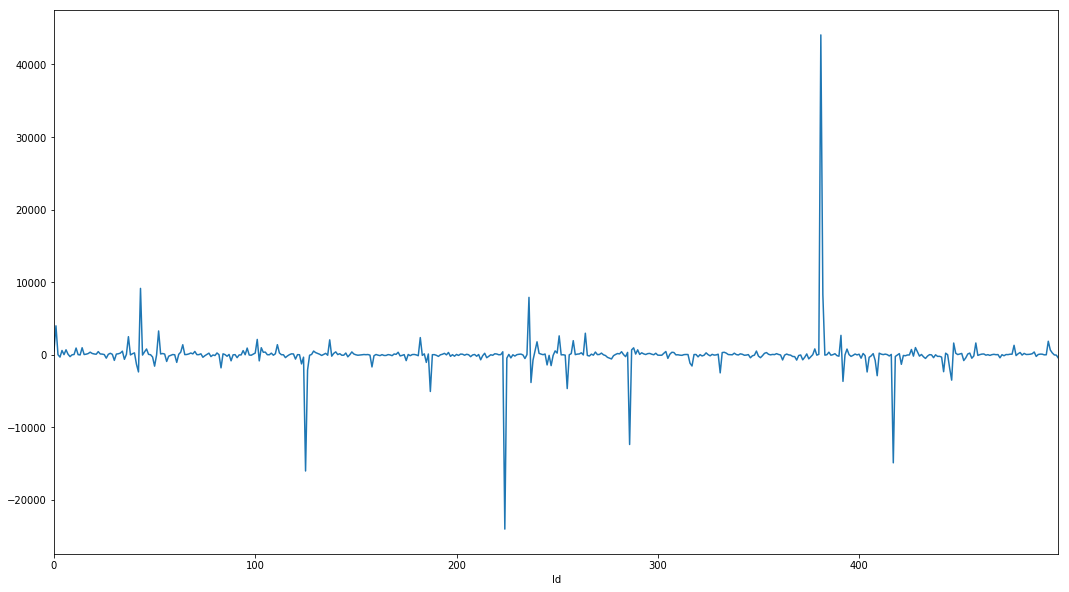

In [39]:
train_Y.plot(figsize=(18, 10))

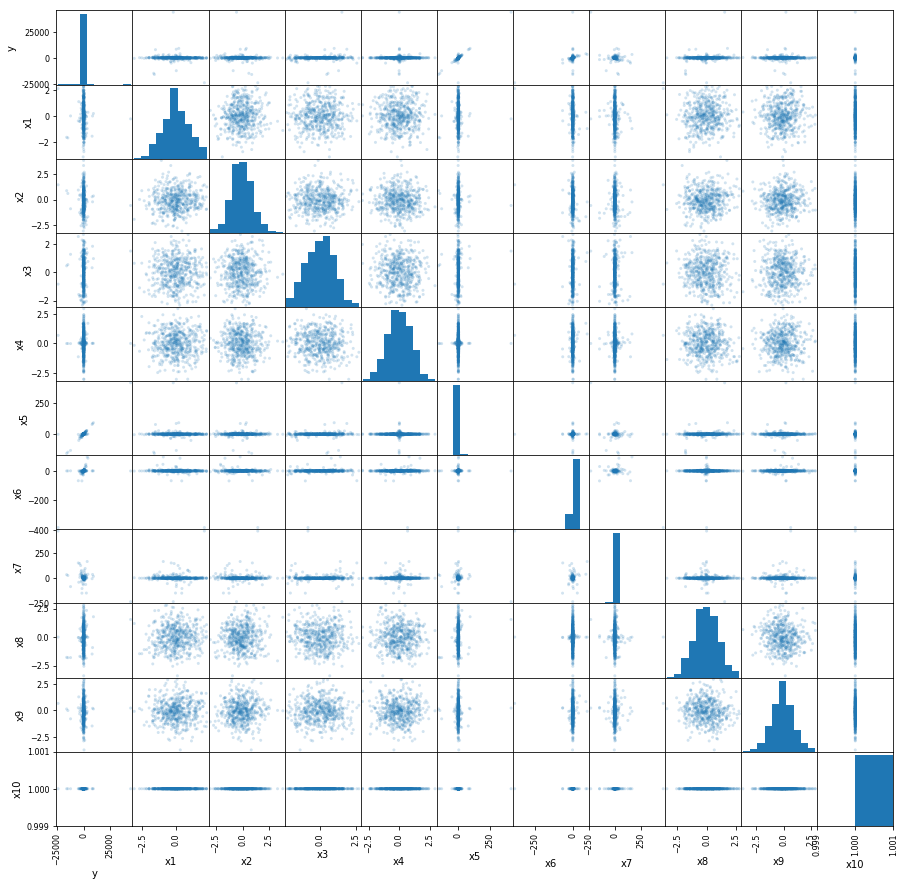

In [95]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(pd.concat([train_Y, train_X], axis=1), alpha=0.2, figsize=(15, 15))

In [96]:
# Based on the plot above, we can essentially concentrate our efforts on x5, x6 and x7
# TODO: Is that actually true? How to interpret the scatter matrix?
train_X_cleaned = train_X.drop(['x1', 'x2', 'x3', 'x4', 'x8', 'x9'], axis=1)

In [105]:
train_X_cleaned = train_X[['x5']]
train_X_cleaned

,x5
Id,
0,8.148069
1,0.455550
2,-0.088216
3,-2.492097
4,5.676019
5,1.625059
6,6.743295
7,0.283798
8,-1.229340


In [109]:
"""
For each of the pre-defined regularization values, we create a Pipeline consisting of a the ridge regressor itself.
If we wanted, we could easily add more steps into the pipeline.
"""

ridge_alphas = [0.1, 1, 10, 100, 1000]

models = {}
for alpha_value in ridge_alphas:
    
    pipeline = Pipeline([('pca', PCA()),
                         ('regr', Ridge(alpha=alpha_value))])
    
    models[alpha_value] = pipeline

param_grid = {'pca__n_components': range(1, len(train_X_cleaned.columns)),
              'regr__random_state': [1], # Fixing the random seed for reproducability
              'regr__normalize': [True, False]
             }

grid_cv_estimators = {}
for alpha_value, ridge_pipe in models.items():
    
    print('Training models with alpha value {}'.format(ridge_pipe.get_params()['regr__alpha']))
    
    grid_cv = GridSearchCV(ridge_pipe, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', verbose=False)
    grid_cv.fit(train_X_cleaned, train_Y)
    grid_cv_estimators[alpha_value] = grid_cv
    
    # print('\tAvg. RMSE of runs: ', grid_cv.cv_results_['mean_test_score'], '\n')

Training models with alpha value 0.1


ValueError: Parameter values for parameter (pca__n_components) need to be a non-empty sequence.

In [107]:
results = []

for alpha_val, cv_estimator in grid_cv_estimators.items():
    print('\n', 10 * '=', 'alpha = {}'.format(alpha_val), 10 * '=', '\n')
    print('Best param set: ')
    pprint(cv_estimator.best_params_)

    cv_results = cv_estimator.cv_results_
    
    best_ranked_idx = np.argmin(cv_results['rank_test_score'])
    results.append(cv_results['mean_test_score'][best_ranked_idx])
    
    print('\n', 10 * '-')
    print('Mean test scores for parameter combinations...')
    for mean, std, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
        print("%0.3f (+/- %0.03f) for %r" % (mean, std * 2, params))
    print(10 * '-')

In [104]:
results = [np.sqrt(-1.0 * entry) for entry in results]  # Since sklearn optimizes for high values of neg_mean_square_error
results  # Will be used as the submitted data

[1.0068957120313748,
 1.003897689911461,
 1.0203339582528799,
 3.269633391240016,
 31.646227821967432]

In [49]:
data_handler.store_results_task1a(results)